In [ ]:
%tensorflow_version 1.x
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
# Loading the required libraries for the modeling
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from skimage.color import rgb2gray
from scipy import ndimage

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import errno
# Image processing
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import skimage
import skimage.io
import skimage.transform
from imageio import imread
import math # MATHEMATICAL OPERATIONS
from glob import glob # FILE OPERATIONS
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
MODEL_PATH='/content/drive/My Drive/Conf_COVID19/'

In [ ]:
from tensorflow.keras import models
classification_model = models.load_model(MODEL_PATH+'model_corona.h5')

In [ ]:
img='79858395-3452-426d-bb99-e01af7961b44.png'
classification_target_size=(224,224)
mask_rcnn_target_size=(256,256)
PNEU='/pneumonia/'
NORMAL='/normal/'

In [ ]:
test_img = cv2.imread(MODEL_PATH+img)
test_img = cv2.resize(test_img,classification_target_size)

In [ ]:
test_img= test_img.reshape(1,224,224,3)

In [ ]:
y = classification_model.predict(test_img)
y_test_non_category = [ np.argmax(t) for t in y ]
for pred in y_test_non_category:
  if pred == 0:
    prediction = 'pneumonia'
  else:
    prediction = 'normal'
prediction

'pneumonia'

In [ ]:
# Import Mask RCNN
#sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
!pip install mrcnn
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', config=inference_config, model_dir=MODEL_PATH)
model_path = os.path.join(MODEL_PATH,'Mask_pneumonia.h5')
model.load_weights(model_path, by_name=True)

In [ ]:
original_image = cv2.imread(MODEL_PATH+img)
original_image = cv2.resize(original_image,mask_rcnn_target_size)

In [ ]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

In [ ]:
# COCO Class names
class_names = ['normal','pneumonia']

In [ ]:
from numpy import expand_dims
original_image = expand_dims(original_image, 0)
original_image.shape

(1, 256, 256, 3)

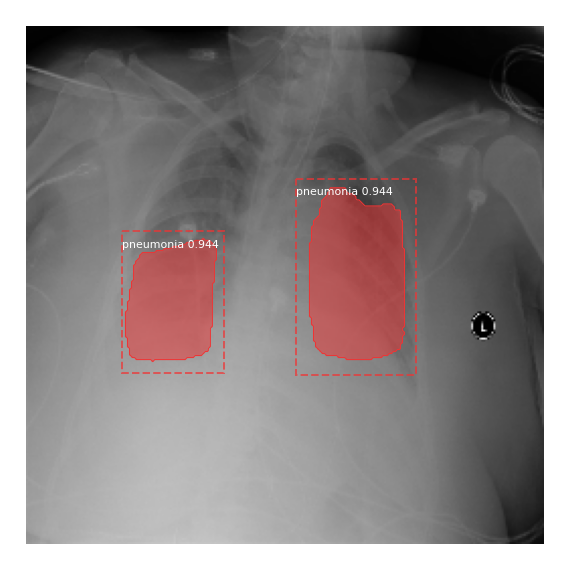

In [ ]:
i=0
results = model.detect(original_image,verbose=0) #, verbose=1)
r = results[0]
fig = plt.figure(figsize=(10, 30))
plt.subplot(1, 1, 1*i + 1)
visualize.display_instances(original_image.reshape(256,256,3), r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'],colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])